<a href="https://colab.research.google.com/github/1394jay/ALY6110/blob/main/ALY6110-Module5%23ParekhJay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
df = spark.sql("show databases")
df.show()


+---------+
|namespace|
+---------+
|  default|
+---------+



In [13]:
from google.colab import files
files.upload()

Saving BostonHousing.csv to BostonHousing (1).csv


{'BostonHousing.csv': b'"crim","zn","indus","chas","nox","rm","age","dis","rad","tax","ptratio","b","lstat","medv"\n0.00632,18,2.31,"0",0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24\n0.02731,0,7.07,"0",0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6\n0.02729,0,7.07,"0",0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7\n0.03237,0,2.18,"0",0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4\n0.06905,0,2.18,"0",0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2\n0.02985,0,2.18,"0",0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7\n0.08829,12.5,7.87,"0",0.524,6.012,66.6,5.5605,5,311,15.2,395.6,12.43,22.9\n0.14455,12.5,7.87,"0",0.524,6.172,96.1,5.9505,5,311,15.2,396.9,19.15,27.1\n0.21124,12.5,7.87,"0",0.524,5.631,100,6.0821,5,311,15.2,386.63,29.93,16.5\n0.17004,12.5,7.87,"0",0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.1,18.9\n0.22489,12.5,7.87,"0",0.524,6.377,94.3,6.3467,5,311,15.2,392.52,20.45,15\n0.11747,12.5,7.87,"0",0.524,6.009,82.9,6.2267,5,311,15.2,396.9,13.27,18.9\n0.09378,12

In [14]:
# Read the given CSV file
dataset =spark.read.csv('BostonHousing.csv',inferSchema=True,header='true')

In [21]:
#Standardize features for principal component analysis
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dataset.toPandas())
scaled_ds = scaler.transform(dataset.toPandas())
scaled_ds.shape
print(scaled_ds)

[[-0.41978194  0.28482986 -1.2879095  ...  0.44105193 -1.0755623
   0.15968566]
 [-0.41733926 -0.48772236 -0.59338101 ...  0.44105193 -0.49243937
  -0.10152429]
 [-0.41734159 -0.48772236 -0.59338101 ...  0.39642699 -1.2087274
   1.32424667]
 ...
 [-0.41344658 -0.48772236  0.11573841 ...  0.44105193 -0.98304761
   0.14880191]
 [-0.40776407 -0.48772236  0.11573841 ...  0.4032249  -0.86530163
  -0.0579893 ]
 [-0.41500016 -0.48772236  0.11573841 ...  0.44105193 -0.66905833
  -1.15724782]]


In [22]:
#Train model for two principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(scaled_ds)
x_pca = pca.transform(scaled_ds)
x_pca.shape

(506, 2)

In [25]:
#Collect distributed data in numpy array and then convert to pandas dataframe
import numpy as np
import pandas as pd

np_array = np.array(x_pca)
pd_df = pd.DataFrame(np_array)
print(pd_df)

            0         1
0   -2.087344  0.492851
1   -1.373382 -0.170925
2   -2.376553  0.914028
3   -2.837779  0.194871
4   -2.772916  0.433301
..        ...       ...
501 -0.302820  0.142758
502 -0.043395 -0.115689
503 -0.368190  0.823161
504 -0.264317  0.540015
505  0.195235 -0.557979

[506 rows x 2 columns]


Text(0, 0.5, 'Second Principle Component')

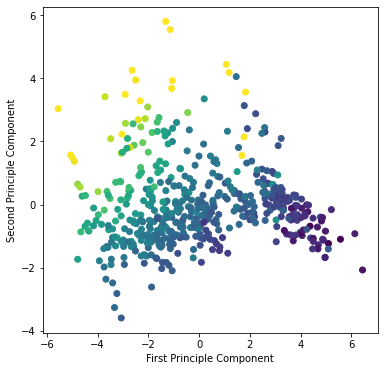

In [27]:
#Plot two principal components
import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=dataset.toPandas()['medv'])
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")


In [31]:
#Combine features to a single vector columns using VectorAssembler (all columns other than target column 'medv')
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat'], outputCol = 'features')
dataset_transformed = vectorAssembler.transform(dataset)
dataset_transformed = dataset_transformed.select(['features', 'medv'])
dataset_transformed.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
+--------------------+----+
only showing top 3 rows



In [32]:
#Standardize features for regression model
from pyspark.ml.feature import StandardScaler

Scalerizer=StandardScaler().setInputCol("features").setOutputCol("features_scaled")
Scalerizer = Scalerizer.fit(dataset_transformed).transform(dataset_transformed)
dataset_transformed = Scalerizer.select('features_scaled', 'medv')

dataset_transformed.show(5)

+--------------------+----+
|     features_scaled|medv|
+--------------------+----+
|[7.34751712931429...|24.0|
|[0.00317501096205...|21.6|
|[0.00317268579840...|34.7|
|[0.00376327736512...|33.4|
|[0.00802762749650...|36.2|
+--------------------+----+
only showing top 5 rows



In [36]:
#Split dataset into training and testing dataset
splits = dataset_transformed.randomSplit([0.7, 0.3])
train_ds = splits[0]
test_ds = splits[1]

In [37]:
#Fit model for linear regression
from pyspark.ml.regression import LinearRegression

regressor = LinearRegression(featuresCol = 'features_scaled', labelCol = 'medv')
model_train = regressor.fit(train_ds)
model_test = regressor.fit(test_ds)


In [39]:
#Find out model coefficients and intercept
pred_test = model_test.evaluate(test_ds)
pred_test.predictions.show(5)

print("Training Coefficients are : " + str(model_train.coefficients))
print("Training Intercept is : " + str(model_train.intercept))

print("Tesing Coefficients are : " + str(model_test.coefficients))
print("Testing Intercept is : " + str(model_test.intercept))

+--------------------+----+------------------+
|     features_scaled|medv|        prediction|
+--------------------+----+------------------+
|[0.00127418967938...|22.0|27.501421914417108|
|[0.00151251895336...|32.7|29.674672494747085|
|[0.00178805084570...|44.0| 37.61119462747074|
|[0.00206707048353...|32.9|30.764481152925374|
|[0.00226819713912...|33.0| 22.71299303037776|
+--------------------+----+------------------+
only showing top 5 rows

Training Coefficients are : [-0.6321959952176893,0.959644405390735,0.14149409817153263,0.6233891203108143,-1.924097123992855,2.926986205487197,-0.06289023034550686,-2.9795219373387583,2.4831678799970365,-2.028953844984895,-2.0835875212935293,0.9727152816564499,-3.6163647143172066]
Training Intercept is : 33.05148340546808
Tesing Coefficients are : [-1.0665882258521877,1.4277620296545859,0.1312462315652243,0.8909956226903571,-2.1045189734561527,1.8783855539973757,0.2959485785336059,-3.171994262267442,2.832237285927351,-2.2185258944312616,-1.956169

In [43]:
#Evaluate model for test dataset

testSummary = model_test.summary
print("RMSE: " + str(testSummary.rootMeanSquaredError))
print("r2: " + str(testSummary.r2))

RMSE: 4.54728508334031
r2: 0.7651990743965285


In [44]:
testSummary = model_train.summary
print("RMSE: " + str(testSummary.rootMeanSquaredError))
print("r2: " + str(testSummary.r2))

RMSE: 4.710751975156807
r2: 0.7321047998474002


In [45]:
print("Train MSE: ", model_train.summary.meanSquaredError)
print("Train MAE: ", model_train.summary.meanAbsoluteError)

print("Test MSE: ", model_test.summary.meanSquaredError)
print("Test MAE: ", model_test.summary.meanAbsoluteError)

Train MSE:  22.19118417144376
Train MAE:  3.3466298985761833
Test MSE:  20.67780162916929
Test MAE:  3.1061017316909525
